In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import importlib
import pandas as pd
import seaborn
from IPython.display import Image
import matplotlib.pyplot as plt

import Transformer as tnsf
import detection_model as ad

importlib.reload(ad)
importlib.reload(tnsf)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
pd.options.display.width = 400
pd.options.display.max_colwidth = 400

## Data Preproccesing

In [46]:
# Parse from file
# Input log file name
log_file  = 'HDFS.log'
log_source  = 'HDFS'
algorithm = 'Spell'
ad.parse(log_source, log_file, algorithm)

Processed 100.0% of log lines.
Parsing done. [Time taken: 0:00:00.438758]


In [26]:
# Original raw logs
N = 10
with open("Dataset/HDFS/HDFS.log") as file:
    for i in range(N): print(next(file).strip())

081109 203518 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010
081109 203518 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906
081109 203519 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010
081109 203519 145 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.14.224:42420 dest: /10.250.14.224:50010
081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_-1608999687919862906 terminating
081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_-1608999687919862906 terminating
081109 203519 145 INFO dfs.DataNode$PacketResponder: Received block blk_-1608999687919862906 of size 91178 from /10.250.10.6
081109 203519 145 INFO dfs.DataNode$PacketResponder: Receiv

In [4]:
# Identified log patterns
log_structured = pd.read_csv("Spell_result/" +  "HDFS_templates.csv") 
log_structured

,EventId,EventTemplate
0,E1,<*>Adding an already existing block<*>
1,E2,<*>Verification succeeded for<*>
2,E3,<*>Served block<*>to<*>
3,E4,<*>Got exception while serving<*>to<*>
4,E5,<*>Receiving block<*>src:<*>dest:<*>
5,E6,<*>Received block<*>src:<*>dest:<*>of size<*>
6,E7,<*>writeBlock<*>received exception<*>
7,E8,<*>PacketResponder<*>for block<*>Interrupted<*>
8,E9,<*>Received block<*>of size<*>from<*>
9,E10,<*>PacketResponder<*>Exception<*>


## Log sequences are divided based on each unique block_id
## Block_ids represent different sessions of log events related to each other

In [5]:
# Log sequences 
# Rows are divided based on each unique block_id
# We create a new row when there is a new block_id in the structured event logs
N = 10
with open("Dataset/HDFS_1/hdfs_train") as file:  # the a opens it in append mode
    for i in range(N):
        print(next(file).strip())

5 5 5 22 11 9 11 9 11 9 26 26 26 23 23 23 21 21 21
22 5 5 5 11 9 11 9 11 9 26 26 26
22 5 5 5 26 26 26 11 9 11 9 11 9 2 3 23 23 23 21 21 21
22 5 5 5 11 9 11 9 11 9 26 26 26
22 5 5 5 26 26 26 11 9 11 9 11 9 4 3 3 3 4 3 4 3 3 4 3 3 23 23 23 21 21 21
22 5 5 5 26 26 26 11 9 11 9 11 9 3 3 4 3 4 3 3 3 4 4 3 3 23 23 23 21 21 21
5 22 5 5 26 26 11 9 11 9 11 9 26 23 23 23 21 21 21
22 5 5 5 26 26 26 11 9 11 9 11 9 4 4 3 2 23 23 23 21 21 21
5 22 5 5 11 9 11 9 11 9 26 26 26 23 23 23 21 21 21
5 5 5 22 11 9 11 9 11 9 26 26 26 23 23 23 21 21 21


## Model Training

In [14]:
# Traning with 4 encoders and decoders, 4 attention heads, and dimension of 512
# Hyperparameters are smaller than those used in NLP since there is a smaller range of combinations
# NLP involves the whole vocabulary of a language, while log detection has a smaller finite number of logs
model = tnsf.train(N=4, d_model=512, d_ff=2048, h=4, dropout=0.1)

4 512 2048 4 0.1


/home/luisselvera/anaconda3/envs/tad/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch Step: 1 Loss: 4.403562 Tokens per Sec: 391.772461
Epoch Step: 1 Loss: 0.343987 Tokens per Sec: 915.370117
tensor(0.3440)
Epoch Step: 1 Loss: 0.563722 Tokens per Sec: 478.919495
Epoch Step: 1 Loss: 0.205848 Tokens per Sec: 828.172302
tensor(0.2058)
Epoch Step: 1 Loss: 1.270140 Tokens per Sec: 378.730072
Epoch Step: 1 Loss: 0.175697 Tokens per Sec: 914.541321
tensor(0.1757)
Epoch Step: 1 Loss: 0.693658 Tokens per Sec: 475.359314
Epoch Step: 1 Loss: 0.238935 Tokens per Sec: 904.409546
tensor(0.2389)
Epoch Step: 1 Loss: 0.943268 Tokens per Sec: 471.581909
Epoch Step: 1 Loss: 0.244257 Tokens per Sec: 897.173828
tensor(0.2443)
Epoch Step: 1 Loss: 0.429745 Tokens per Sec: 399.891785
Epoch Step: 1 Loss: 0.239586 Tokens per Sec: 910.637939
tensor(0.2396)
Epoch Step: 1 Loss: 0.594788 Tokens per Sec: 477.464447
Epoch Step: 1 Loss: 0.236024 Tokens per Sec: 679.672424
tensor(0.2360)
Epoch Step: 1 Loss: 0.713302 Tokens per Sec: 395.671295
Epoch Step: 1 Loss: 0.229155 Tokens per Sec: 909.131104

## Model evaluation

In [15]:
tnsf.test(model)

553366
553366
16838
16838
0
1000
2000
3000
4000
0
1000
2000
3000
4000
True positive (TP): 5000, 
true negative (TN): 4653, 
false positive (FP): 347, 
false negative (FN): 0, 
Accuracy: 96.530%, 
Precision: 93.510%, 
Recall: 100.000%, 
F1-measure: 96.646%
elapsed_time: 476.210s


## Visualization

In [4]:
#We create log sequences with 10 log keys
WINDOW_SIZE = 10

In [31]:
model = torch.load("Model/centralized_models.pt")
model.eval()

# Parameter
WINDOW_SIZE = 10

# Log sequence
#5 5 22 5 11 9 11 9 11 9 26 26 26 23 23 23 21 21 21 20
# seq = [5, 5, 22, 5, 11, 9, 11, 9, 11, 9, 26, 26, 26, 23, 23, 23, 21, 21, 21, 20]
seq = [22, 5, 5, 5, 26, 26, 26, 11, 9, 11, 9, 11, 9, 3, 3, 4, 3, 4, 3, 3]

#Input log sequence
src = seq[:WINDOW_SIZE]
#Output log sequence
tgt = seq[WINDOW_SIZE:]
# src = [5, 5, 22, 5, 11, 9, 11, 9, 11, 9]
# tgt = [26, 26, 26, 23, 23, 23, 21, 21, 21, 20]

# Input log sequence
src = seq[:WINDOW_SIZE]
# Expected log sequence
tgt = seq[WINDOW_SIZE:]

src_mask = Variable(torch.ones(1, 1, WINDOW_SIZE+1) )

t1 = torch.from_numpy(np.zeros((1,WINDOW_SIZE+1),dtype=int))
t1[0][1:WINDOW_SIZE+1] = torch.tensor(src, dtype=torch.float).to(device)
t1[0][0]=1

t2 = torch.from_numpy(np.zeros((1,WINDOW_SIZE+1),dtype=int))
t2[0][0:len(tgt)] = torch.tensor(tgt, dtype=torch.float).to(device)

tgt = Variable(t2, requires_grad=False)
src = Variable(t1, requires_grad=False)

# Predicted log sequence
tgt_pred = tnsf.greedy_decode(model, src, src_mask, tgt, WINDOW_SIZE+1, 1, False, 9) 

In [32]:
src= src[0][1:]
tgt_pred = np.reshape(tgt_pred.numpy(), (10,))
src = list(np.reshape(src.numpy(), (10,)))

In [33]:
def draw(data, x, y, ax, cbar_ax):
    seaborn.heatmap(data, xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0,annot=False, cbar_ax=cbar_ax,cbar=True, ax=ax)

### Horizontal axis represents the logs the model is predicting. 
### Vertical axis are the logs that the model is focusing on, applying attention, to predict next log on horizontal axis.

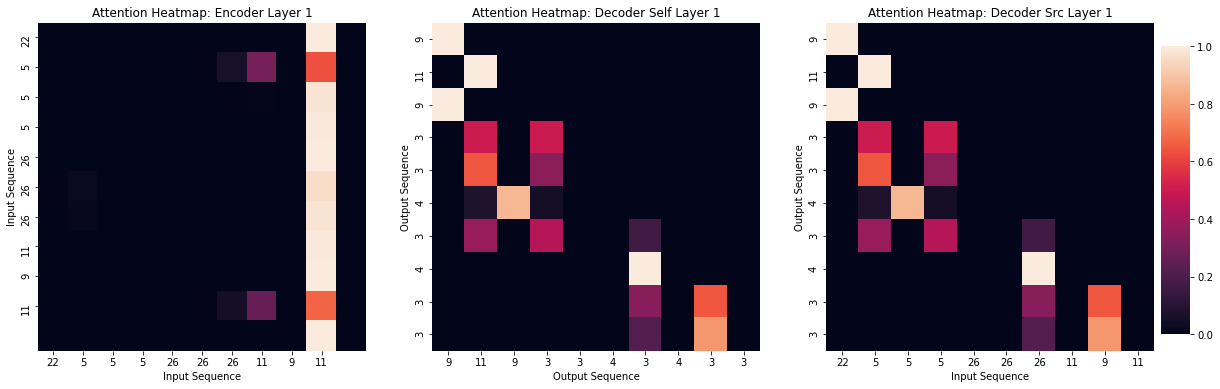

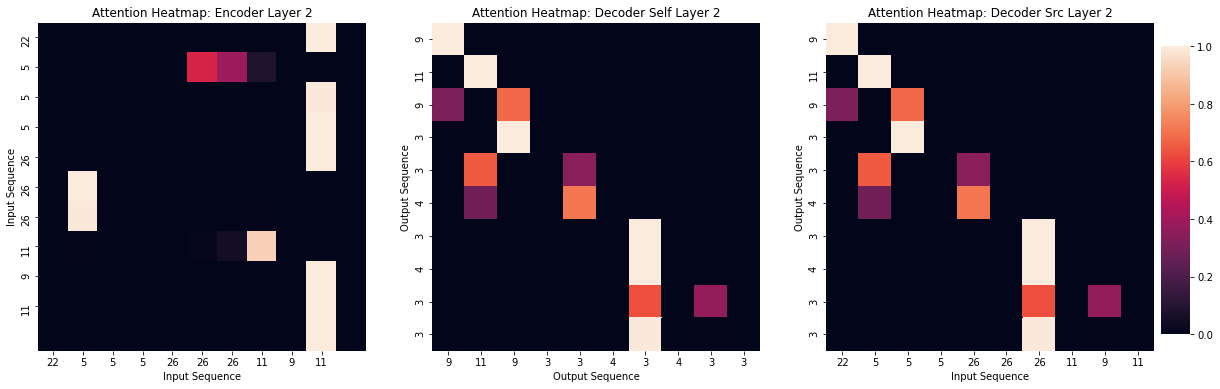

In [34]:
#Attention heatmatp
r = 0
for layer in range(2):
    fig, axs = plt.subplots(1,3, figsize=(20, 20))
    cbar_ax = fig.add_axes([.905, .4, .02, .2])
    for h in range(1):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, src, src if h ==0 else [], ax=axs[r], cbar_ax=cbar_ax )
        axs[r].set_xlabel('Input Sequence')
        axs[r].set_ylabel('Input Sequence')
        axs[r].set_title("Attention Heatmap: Encoder Layer " + str(layer+1))
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_pred), :len(tgt_pred)], tgt_pred, tgt_pred if h ==0 else [], ax=axs[r+1], cbar_ax=cbar_ax )
        axs[r + 1].set_xlabel('Output Sequence')
        axs[r + 1].set_ylabel('Output Sequence')        
        axs[r + 1].set_title("Attention Heatmap: Decoder Self Layer " + str(layer+1))
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_pred), :len(src)], src, tgt_pred if h ==0 else [], ax=axs[r+2], cbar_ax=cbar_ax )
        axs[r + 2].set_xlabel('Input Sequence')
        axs[r + 2].set_ylabel('Output Sequence')
        axs[r + 2].set_title("Attention Heatmap: Decoder Src Layer " + str(layer+1))
        
    plt.show()

|  | <font size="4">Positive</font>  | <font size="4">Negative</font> |
| --- | --- | --- |
| <font size="4">**True**</font> | <font size="4">There is a problem and alarm turns on </font>| <font size="4">There is no problem and no alarm </font>|
| <font size="4">**False**</font> | <font size="4">There is no problem but alarm turns on</font> | <font size="4">There is a problem but no alarm</font> |

## Normal behavior log sequence

In [35]:
# 22 5 5 5 26 26 26 11 9 11 9 11 9 3 3 4 3 4 3 3 3 4 3 3 4 23 23 23 21 21 21 
#Log sequence
seq = [22, 5, 5, 5, 26, 26, 26, 11, 9, 11, 9, 11, 9, 3, 3, 4, 3, 4, 3, 3]

#Input log sequence
src = seq[:WINDOW_SIZE]
#Output log sequence
tgt = seq[WINDOW_SIZE:]

t1 = torch.from_numpy(np.zeros((1,WINDOW_SIZE+1),dtype=int))
t1[0][1:WINDOW_SIZE+1] = torch.tensor(src, dtype=torch.float).to(device)
t1[0][0]=1

t2 = torch.from_numpy(np.zeros((1,WINDOW_SIZE+1),dtype=int))
t2[0][0:len(tgt)] = torch.tensor(tgt, dtype=torch.float).to(device)

tgt = Variable(t2, requires_grad=False)
src = Variable(t1, requires_grad=False)

#Predict log sequence
tgt_pred = tnsf.greedy_decode(model, src, src_mask, tgt, WINDOW_SIZE+1, 1, True, 9) 

if -1 in tgt_pred: print("Abnormal log sequence: false positive")
else: print("Normal log sequence: true negative\n", tgt_pred)

Incoming log: tensor(9)
Candidate logs: tensor([18, 16, 25, 15,  6, 21, 23, 11,  9]) 

Incoming log: tensor(11)
Candidate logs: tensor([27, 10,  2,  3, 26, 19,  4,  9, 11]) 

Incoming log: tensor(9)
Candidate logs: tensor([18, 16, 25, 15,  6, 21, 23, 11,  9]) 

Incoming log: tensor(3)
Candidate logs: tensor([14, 21,  9, 23, 26, 11,  2,  3,  4]) 

Incoming log: tensor(3)
Candidate logs: tensor([18,  9, 14, 26, 23,  2, 11,  4,  3]) 

Incoming log: tensor(4)
Candidate logs: tensor([14, 26,  9, 21, 23, 11,  2,  4,  3]) 

Incoming log: tensor(3)
Candidate logs: tensor([14, 21,  9, 26, 11, 23,  2,  4,  3]) 

Incoming log: tensor(4)
Candidate logs: tensor([14, 26,  9, 11, 21, 23,  2,  3,  4]) 

Incoming log: tensor(3)
Candidate logs: tensor([14, 26,  9, 11, 21, 23,  2,  4,  3]) 

Incoming log: tensor(3)
Candidate logs: tensor([14, 26, 21, 23,  9, 11,  2,  4,  3]) 

Normal log sequence: true negative
 tensor([[ 9, 11,  9,  3,  3,  4,  3,  4,  3,  3]])


## Abnormal behavior log sequence

In [36]:
#Log sequence

seq = [ 5, 22, 11, 9, 11, 9, 11, 9, 26, 26, 26, 23, 23, 23, 21, 21, 21, 20, 20, 20]
#Input log sequence
src = seq[:WINDOW_SIZE]
#Output log sequence
tgt = seq[WINDOW_SIZE:]

t1 = torch.from_numpy(np.zeros((1,WINDOW_SIZE+1),dtype=int))
t1[0][0]=1
t1[0][1:WINDOW_SIZE+1] = torch.tensor(src, dtype=torch.float).to(device)


src = Variable(t1, requires_grad=False)
t2[0][0:len(tgt)] = torch.tensor(tgt, dtype=torch.float).to(device)
tgt = Variable(t2, requires_grad=False)

#Predict log sequence
tgt_pred = tnsf.greedy_decode(model, src, src_mask, tgt, WINDOW_SIZE+1, 1, True, 9) 

#If -1 in predicted sequence, anomaly detected
if -1 in tgt_pred: 
    print("Abnormal log sequence: true positive\n", tgt_pred)
#Otherwise, no anomaly was detected
else: 
    print("Normal log sequence: false negative")

Incoming log: tensor(26)
Candidate logs: tensor([18, 16, 25, 15,  6, 21, 23,  9, 11]) 

Abnormal log sequence: true positive
 tensor([[26, -1]])


In [39]:
algorithm

'Spell'

## Find logs that caused anomaly

In [41]:
#Backtrack to logs that caused anomaly
ad.backtrace(tgt_pred, log_source, algorithm)

26 <*>BLOCK* NameSystem<*>addStoredBlock: blockMap updated:<*>is added to<*>size<*>


## Mapping between log key and event templates

In [281]:
#Mapping between log key and event template
log_structured = pd.read_csv("Spell_result/" +  "HDFS_templates.csv") 
log_structured

,EventId,EventTemplate
0,E1,<*>Adding an already existing block<*>
1,E2,<*>Verification succeeded for<*>
2,E3,<*>Served block<*>to<*>
3,E4,<*>Got exception while serving<*>to<*>
4,E5,<*>Receiving block<*>src:<*>dest:<*>
5,E6,<*>Received block<*>src:<*>dest:<*>of size<*>
6,E7,<*>writeBlock<*>received exception<*>
7,E8,<*>PacketResponder<*>for block<*>Interrupted<*>
8,E9,<*>Received block<*>of size<*>from<*>
9,E10,<*>PacketResponder<*>Exception<*>
